In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
import functools
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'
# path_to_git = '/home/kentaro/github/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=3,style='whitegrid')

In [4]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Bias in CNN (DenseNet)

In [44]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}
tuning_params = [-0.1,-0.05,0.05,0.1]
for problem in tqdm.tqdm( tuning_params ):
    type_summary = 'max'
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission', 
                'hydrocephalus  (either on admission or during hospital course)   QPID', 
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['mRS'] = df_coarsen_1['mRS'] + problem
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 5
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = str(problem) + str(threshold)
        
    m_dict_dict[problem] = m_dict
    cates_dict_dict[problem] = cates_dict
    df_dict_dict[problem] = df_dict
    df_means_dict[problem] = df_means

df_m_atec_dict = {}
for problem in m_dict_dict.keys():
    m_dict = m_dict_dict[problem]
    df_dict = df_dict_dict[problem]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[problem] = df_m_atec

for problem in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[problem]
    df_m_atec.to_csv('df_sensitivity_m_atec_'+str(problem)+'_c.csv')

for problem in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[problem].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$Y(E_{%s} \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$'%(type_summary))
    plt.xlabel('$threshold$')
    plt.title('%.2f'%(problem))
    fig.savefig(str(problem)+'_sensitivity_c.png')

ates = pd.concat([df_m_atec_dict[problem].T for problem in m_dict_dict.keys()])
ates['sensitivity parameter'] = functools.reduce(lambda x,y: x+y, map(lambda x: [x for i in range(15)],tuning_params) )

fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
fig.savefig('sensitivity_max_c.png')

100%|██████████| 4/4 [42:41<00:00, 640.28s/it]


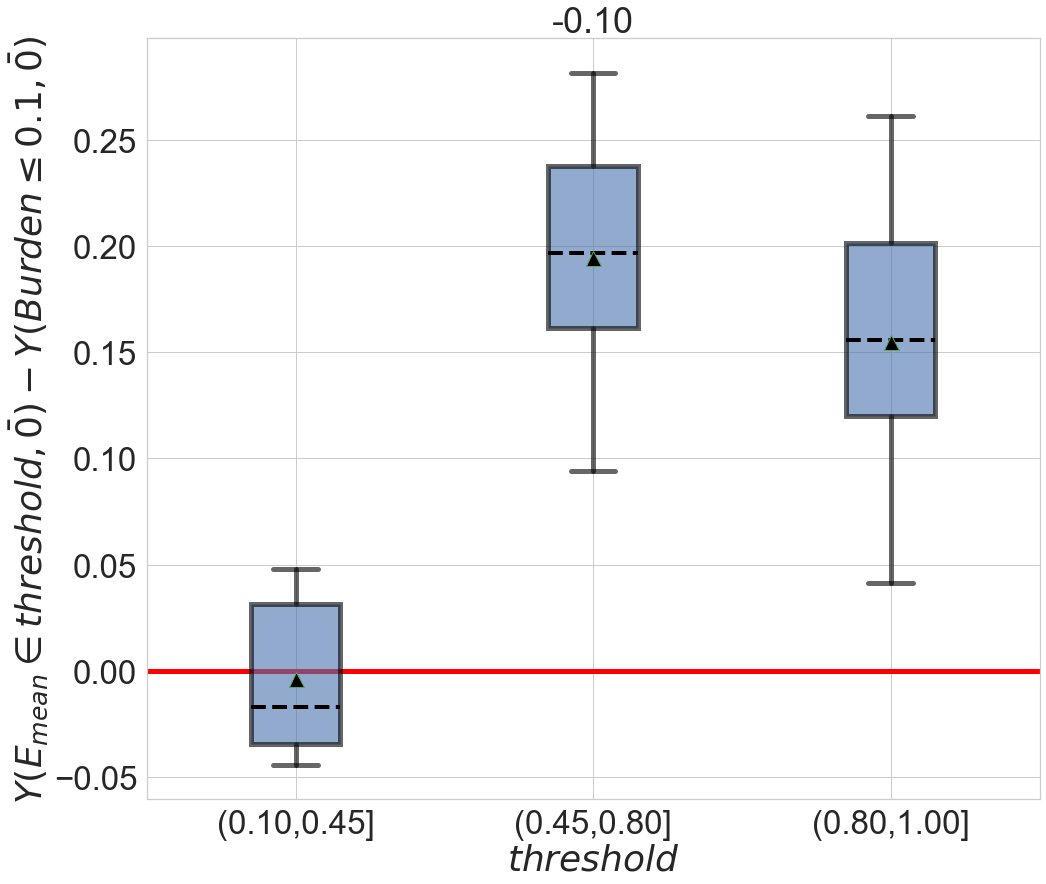

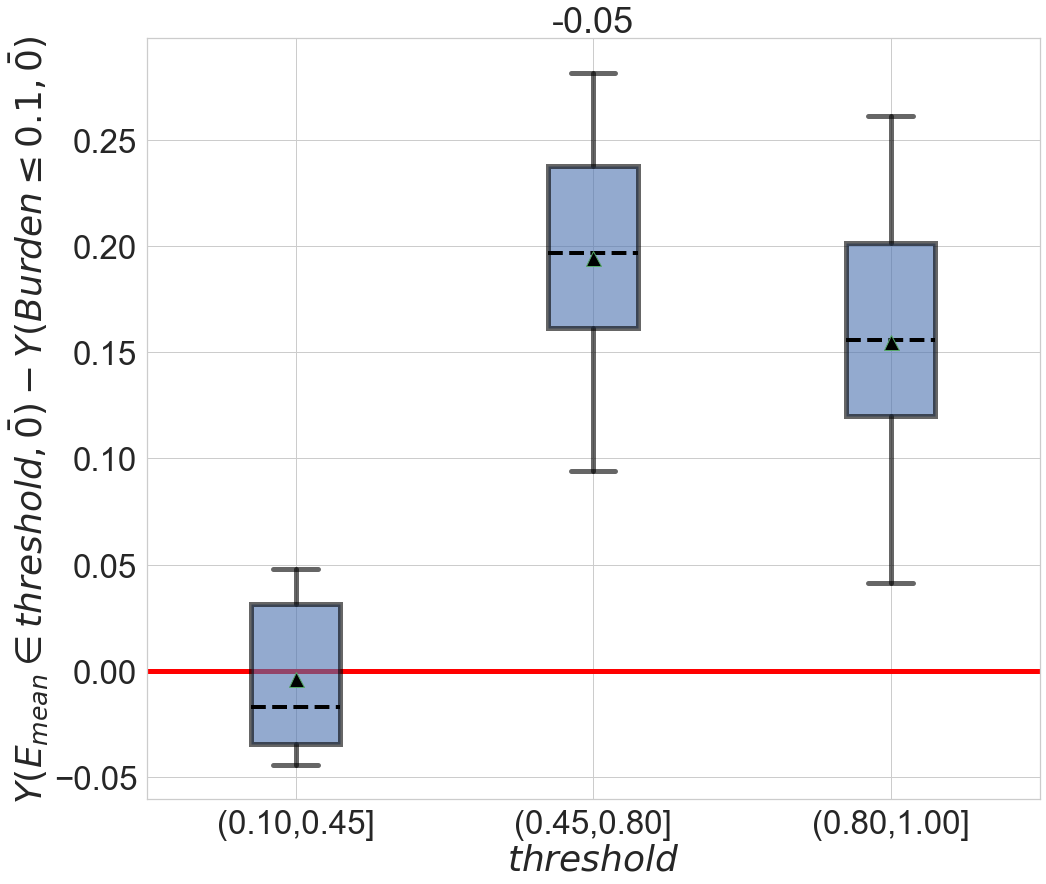

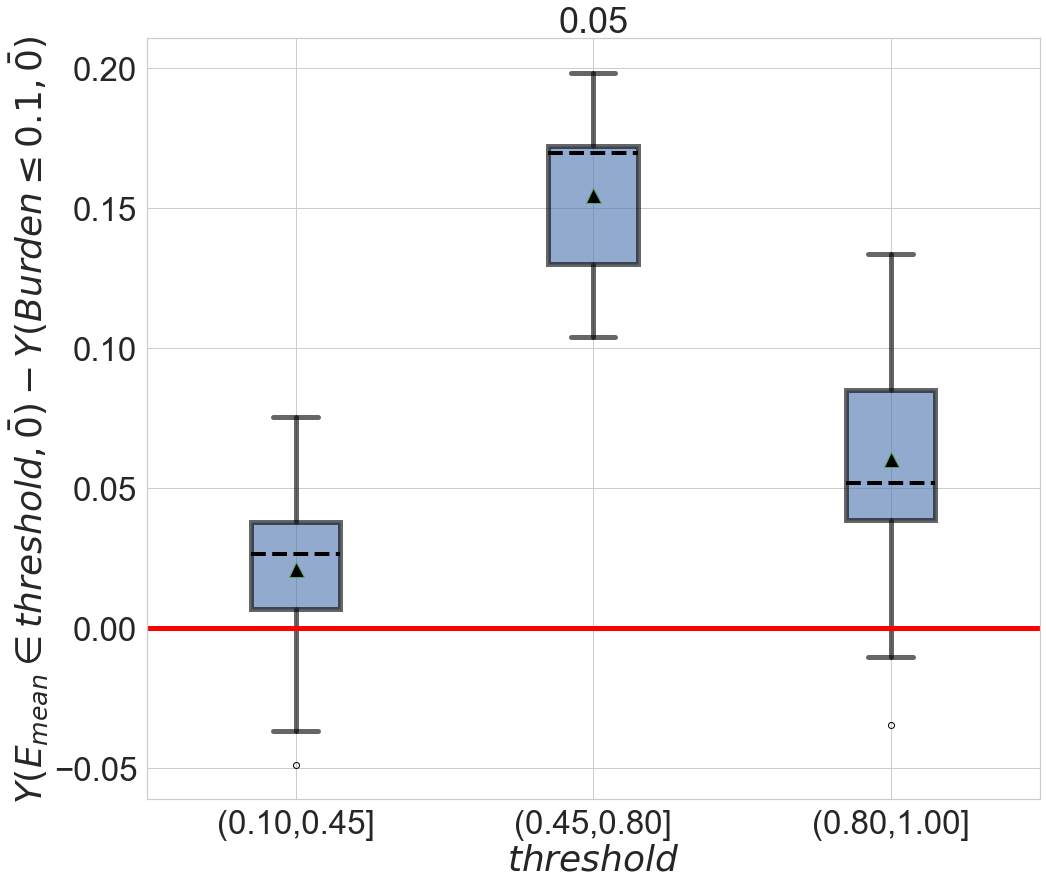

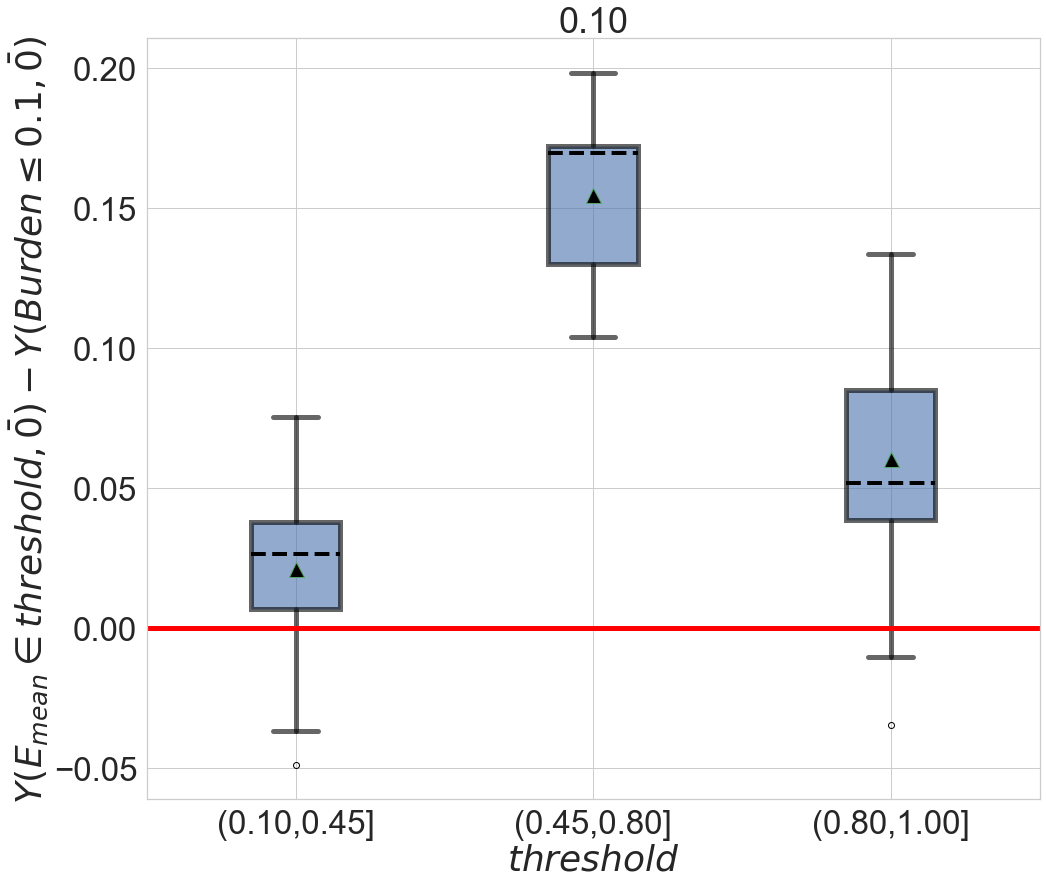

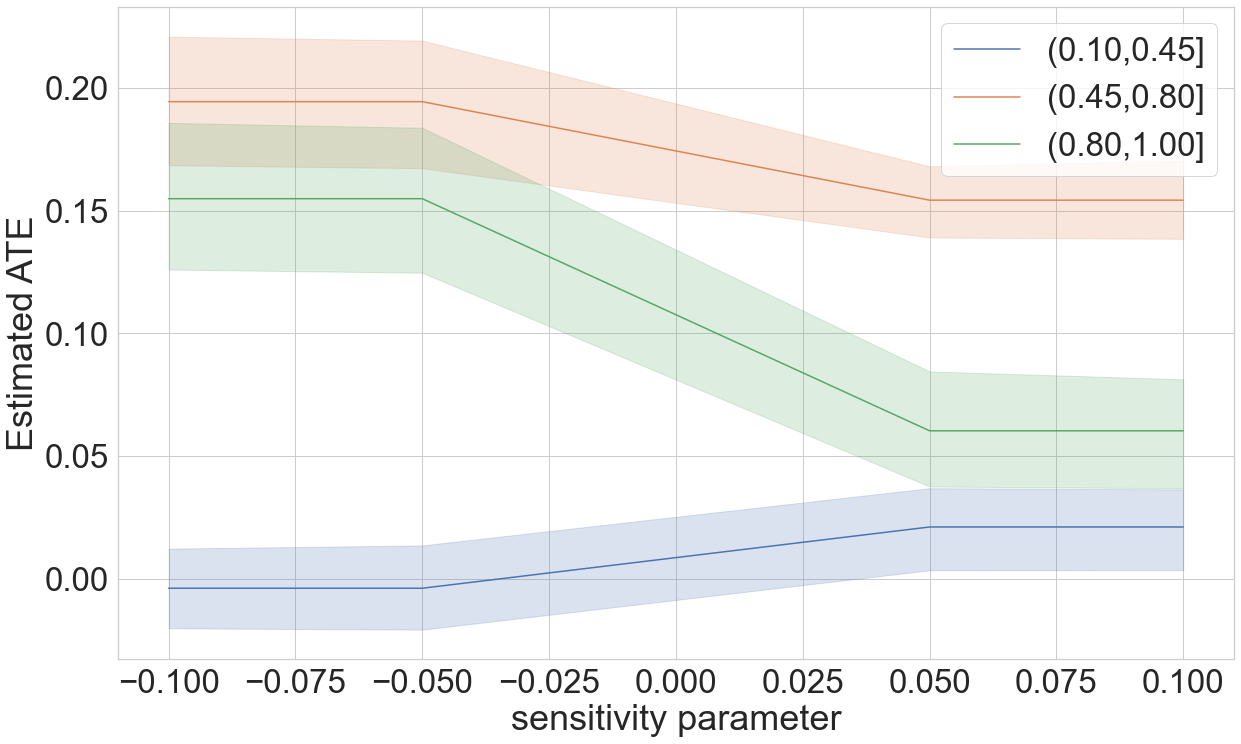

In [45]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}
tuning_params = [-0.1,-0.05,0.05,0.1]
for problem in tqdm.tqdm( tuning_params ):
    type_summary = 'mean'
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission', 
                'hydrocephalus  (either on admission or during hospital course)   QPID', 
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['mRS'] = df_coarsen_1['mRS'] + problem
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 5
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = str(problem) + str(threshold)
        
    m_dict_dict[problem] = m_dict
    cates_dict_dict[problem] = cates_dict
    df_dict_dict[problem] = df_dict
    df_means_dict[problem] = df_means

df_m_atec_dict = {}
for problem in m_dict_dict.keys():
    m_dict = m_dict_dict[problem]
    df_dict = df_dict_dict[problem]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[problem] = df_m_atec

for problem in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[problem]
    df_m_atec.to_csv('df_sensitivity_m_atec_'+str(problem)+'_c.csv')

for problem in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[problem].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$Y(E_{%s} \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$'%(type_summary))
    plt.xlabel('$threshold$')
    plt.title('%.2f'%(problem))
    fig.savefig(str(problem)+'_sensitivity_c.png')

ates = pd.concat([df_m_atec_dict[problem].T for problem in m_dict_dict.keys()])
ates['sensitivity parameter'] = functools.reduce(lambda x,y: x+y, map(lambda x: [x for i in range(15)],tuning_params) )

fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
fig.savefig('sensitivity_mean_c.png')

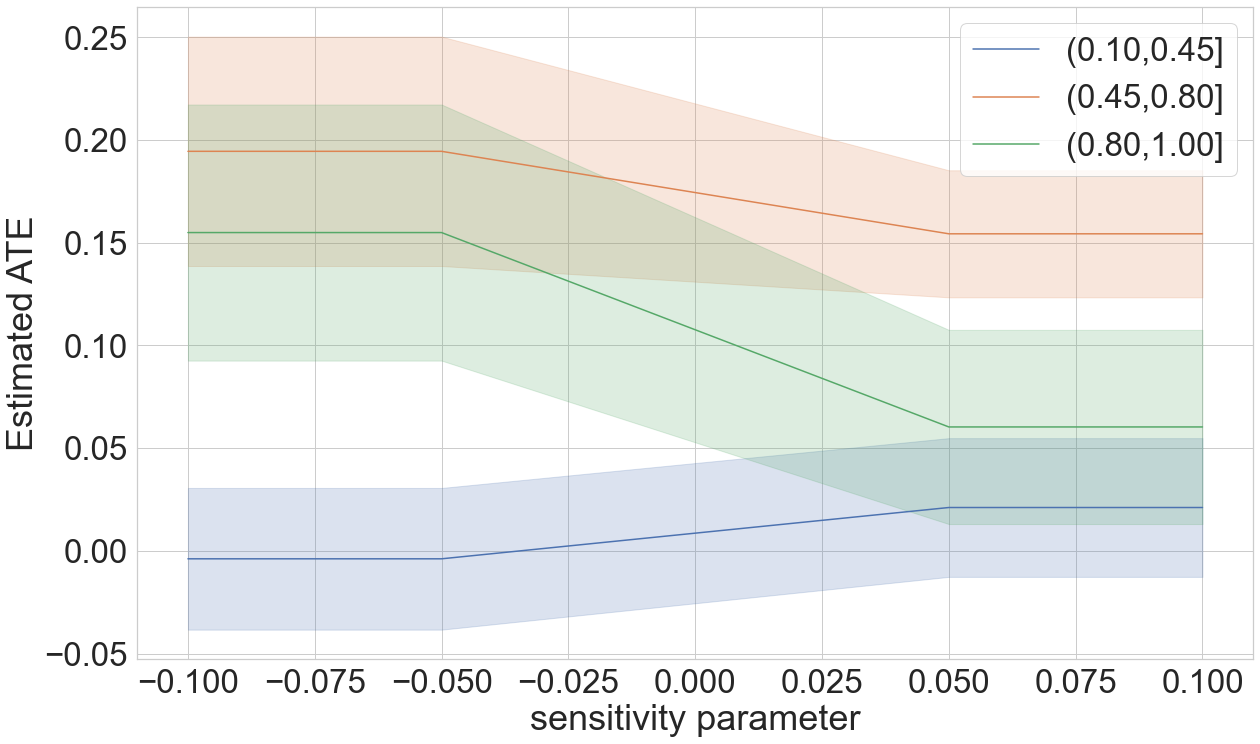

In [48]:

fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
fig.savefig('sensitivity_mean_c.png')

# Unobserved confounder

$q(t,x) = E[Y_i(t) | T_i = t, X_i = x] - E[Y_i(t) | T_i = 1-t, X_i = x]$ \
$Y_{i,updated} = Y_i - q(T_i,X_i) (1 - Pr(T_i | X_i ))$

There is an unobserved confounder which is causing units with bad outcomes into treatment and units with good outcomes into control.
$q(t,x) = \psi (2t - 1)$

100%|██████████| 11/11 [1:04:45<00:00, 353.26s/it]


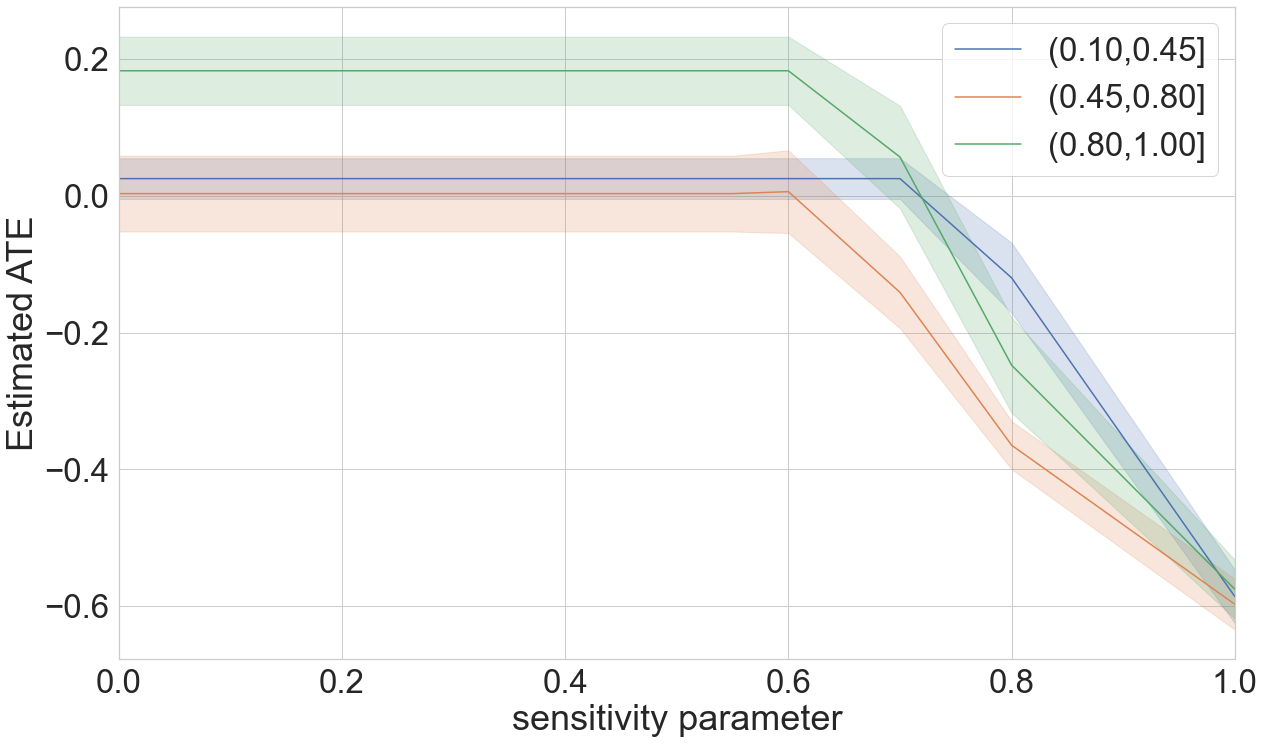

In [20]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}
tuning_params = [0,0.25,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,1]
def q(t,psi):
    return psi*(2*t - 1)   
    
for problem in tqdm.tqdm( tuning_params ):
    type_summary = 'max'
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                              'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                                'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission', 
                'hydrocephalus  (either on admission or during hospital course)   QPID', 
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['mRS'] = df_coarsen_1['mRS']
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        Y_obs = df_malts['mRS'] > 3
        prop_score = lm.LogisticRegressionCV().fit(df_malts.drop(columns=['mRS','E','T','Y','lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']),df_malts['T'])
        prop_score_vals = prop_score.predict_proba(df_malts.drop(columns=['mRS','E','T','Y','lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']))[:,1]
        Y_upd = ( ( Y_obs.values - ( q(df_malts['T'].values,problem) * ( df_malts['T'].values*(1 - prop_score_vals) + (1-df_malts['T'].values)*prop_score_vals ) ) ) >= 0.5 ).astype(int)
        df_malts['Y']  = Y_upd
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 5
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = str(problem) + str(threshold)
        
    m_dict_dict[problem] = m_dict
    cates_dict_dict[problem] = cates_dict
    df_dict_dict[problem] = df_dict
    df_means_dict[problem] = df_means

df_m_atec_dict = {}
for problem in m_dict_dict.keys():
    m_dict = m_dict_dict[problem]
    df_dict = df_dict_dict[problem]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[problem] = df_m_atec

for problem in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[problem]
    df_m_atec.to_csv('df_unobs_conf_m_atec_'+str(problem)+'_c.csv')

# for problem in m_dict_dict.keys():
#     fig,ax = plt.subplots(figsize=(16,14))
#     df_m_atec_dict[problem].T.plot(kind='box',showmeans=True,
#                                         ax=ax,
#                                         patch_artist=True,
# #                                         meanline=True,
#                                         capprops={'alpha':0.6,'lw':5},
#                                         whiskerprops = {'alpha':0.6,'lw':5},
#                                         boxprops={'alpha':0.6,'lw':5},
#                                         medianprops={'lw':4,'color':'black','ls':'--'},
#                                         meanprops={'markersize':15,'markerfacecolor':'black'})
#     plt.axhline(0,c='red',lw=5)
#     plt.ylabel('$Y(E_{%s} \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$'%(type_summary))
#     plt.xlabel('$threshold$')
#     plt.title('%.2f'%(problem))
#     fig.savefig(str(problem)+'_unobs_conf_c.png')

ates = pd.concat([df_m_atec_dict[problem].T for problem in m_dict_dict.keys()])
ates['sensitivity parameter'] = functools.reduce(lambda x,y: x+y, map(lambda x: [x for i in range(15)],tuning_params) )

fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
plt.xlim((0,1))
fig.savefig('unobs_conf_max_c.png')

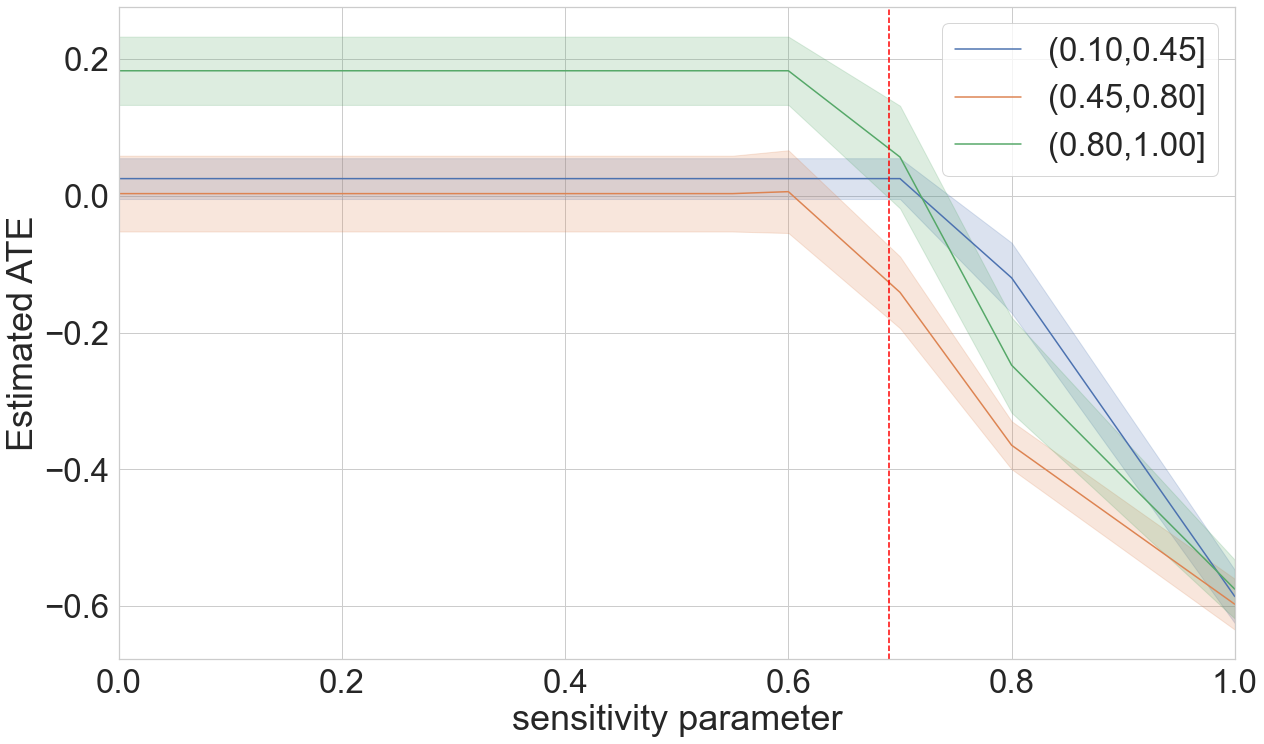

In [25]:
fig = plt.figure(figsize=(20,12))
sns.lineplot(x='sensitivity parameter',y='(0.10,0.45]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.45,0.80]',data=ates,ci="sd")
sns.lineplot(x='sensitivity parameter',y='(0.80,1.00]',data=ates,ci="sd")
plt.legend(['(0.10,0.45]','(0.45,0.80]','(0.80,1.00]'],loc='upper right')
plt.ylabel('Estimated ATE')
plt.xlim((0,1))
plt.axvline(0.69,c='red',ls='--')
fig.savefig('unobs_conf_max_c.png')